## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

Required imports

In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scraper
import utils
import numpy as np
import pandas as pd

from nltk import FreqDist
import pathlib
from multiprocessing import Pool
import pickle

plt.rcParams['figure.figsize'] = [10, 8]

If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

Changes?
> `pip freeze > requirements.txt`

## Downloading the data

In [61]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)

Fetching 3 categories:   0%|          | 0/3 [00:00<?, ?it/s]

Creating graph: 100%|██████████| 7357/7357 [00:02<00:00, 3092.37it/s] 

Total edges: 210596


A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)

In [62]:
infos.keys()

dict_keys(['titles', 'archive_titles'])

In [63]:
talk_pages = [title for title in page_graph.nodes if title[:5] == "Talk:"]
users = [title for title in page_graph.nodes if title[:5] == "User:"]
print("Number of pages in the vital articles dataset:", len(infos["titles"]))
print("Number of related archived pages:", len(infos["archive_titles"]))
print("Number of users found in relation to the dataset:", len(users))
print("No. nodes", page_graph.number_of_nodes())
print("No. links:", page_graph.number_of_edges())

Number of pages in the vital articles dataset: 1001
Number of related archived pages: 6356
Number of users found in relation to the dataset: 79506
No. nodes 81508
No. links: 162089


> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)

In [64]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 10:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

KeyboardInterrupt: 

In [ ]:
# sorted(rsubgraph.degree, key=lambda item: item[1], reverse=True)[:10]
import pandas as pd

degrees = pd.DataFrame(rsubgraph.degree, columns=["Node", "Degree"])
degrees.head()

,Node,Degree
0,Talk:Earth,27
1,Earth,1
2,Talk:Human,25
3,Human,1
4,Talk:Human history,16


In [ ]:
degrees["PageType"] = ["User" if node[:5] == "User:" else "Talk" for node in degrees.Node ]
users = degrees[degrees.PageType == "User"]
potential_bots = users[users["Node"].str.contains('bot', case=False)]
print(f"{len(potential_bots)} users found with with bot in their name:")
print(",\n".join(potential_bots.Node.values))

5 users found with with bot in their name:
User:Community Tech bot,
User:PrimeBOT,
User:InternetArchiveBot,
User:Cyberbot II,
User:CommonsNotificationBot


After evaluation we found that `User:Botteville`, `User:KP Botany` and `User:NinjaRobotPirate` are human users. Therefore we can filter out the bots by name.


In [ ]:
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]

human_users = users[~users["Node"].isin(bot_names)]
n = 10
top_n_human_df = human_users.sort_values(["Degree"], ascending=False).head(n)
top_n_human_df

,Node,Degree,PageType
247,User:Oneiros,38,User
210,User:ScottishFinnishRadish,24,User
229,User:Arjayay,24,User
245,User:Beland,23,User
217,User:Cannolis,22,User
237,User:BozMo,21,User
234,User:Deacon Vorbis,19,User
216,User:Vsmith,19,User
201,User:Piotrus,18,User
205,User:Northamerica1000,18,User


Make subgraph with users and their related pages.



In [ ]:
top_n_human_names = top_n_human_df.Node.values
top_users_graph = graph.subgraph(sum([list(graph.neighbors(node)) + [node] for node in top_n_human_names], []))
pages = [node for node in top_users_graph.nodes if node not in top_n_human_names] 

node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in top_users_graph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in top_users_graph.nodes]

In [ ]:
degrees = dict(top_users_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
top_nodes_count = 10
top_nodes = [node for node in sorted(degrees, key=degrees.get, reverse=True) if node[:5] == "Talk:"][:top_nodes_count]
labels = {node: node for node in top_nodes}

In [ ]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=2.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
pos=forceatlas2.forceatlas2_networkx_layout(top_users_graph, pos=None, iterations=2000)
    
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5)
plt.show()

ModuleNotFoundError: No module named 'fa2'

In [ ]:
pos = nx.spring_layout(top_users_graph)
label_pos = {node: (pos[node][0], pos[node][1] + 0.15) for node in top_nodes}
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5, with_labels=False)
nx.draw_networkx_labels(top_users_graph, pos, labels=labels, font_size=10, font_color='black')
plt.show()

NameError: name 'top_users_graph' is not defined

## Basic Analysis

In [ ]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

# Basic Statistics

count_nodes = len(page_graph)
count_edges = len(page_graph.edges())

# Create degree statistic dicts
degrees = dict(page_graph.degree())
in_degrees = dict(page_graph.in_degree())
out_degrees = dict(page_graph.out_degree())

talk_page_in_degrees = {k: v for k, v in in_degrees.items() if page_graph.nodes[k]["page_class"] == "talk"}
user_out_degrees = {k: v for k, v in out_degrees.items() if page_graph.nodes[k]["page_class"] == "user"}

def find_top(n, stat_dict):
    degrees_pages = []
    degrees_users = []
    top_overall = ""

    for page, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = page + " - " + str(degree)

        # stat dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_pages) < n and page_graph.nodes[page]["page_class"] == "talk": 
            degrees_pages.append(page + " - " + str(degree))
        elif len(degrees_users) < n and page_graph.nodes[page]["page_class"] == "user":
            degrees_users.append(page + " - " + str(degree))

        if len(degrees_pages) >= n and len(degrees_users) >= n:
            break  # found all top v
    
    return degrees_pages, degrees_users, top_overall

degrees_pages, degrees_users, top_overall = find_top(10, degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Highest degrees for pages:")
print("> Overall:")
print(top_overall)
print("> Pages:")
print("\n".join(degrees_pages))
print("> Users:")
print("\n".join(degrees_users))


# Degree multiplicities
in_degrees_counts = p.Series(talk_page_in_degrees.values()).value_counts()
out_degrees_counts = p.Series(user_out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(1, max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

Number of nodes: 81481
Number of links: 162045

Highest degrees for pages:
> Overall:
Talk:United States - 2223
> Pages:
Talk:United States - 2223
Talk:Jesus - 1877
Talk:Climate change - 1771
Talk:India - 1607
Talk:Israel - 1606
Talk:Adolf Hitler - 1537
Talk:Michael Jackson - 1437
Talk:Muhammad - 1399
Talk:World War II - 1274
Talk:United Kingdom - 1192
> Users:
User:InternetArchiveBot - 801
User:Cyberbot II - 391
User:PrimeBOT - 324
User:Community Tech bot - 259
User:ScottishFinnishRadish - 235
User:Arjayay - 215
User:Cannolis - 205
User:CommonsNotificationBot - 160
User:Deacon Vorbis - 138
User:Kuyabribri - 138
Exponents:ess: 97%
In-degrees: 3.5080948687862707 sigma: 0.25732510403505693
Out-degrees: 1.5385136348779775 sigma: 0.11751330926638778


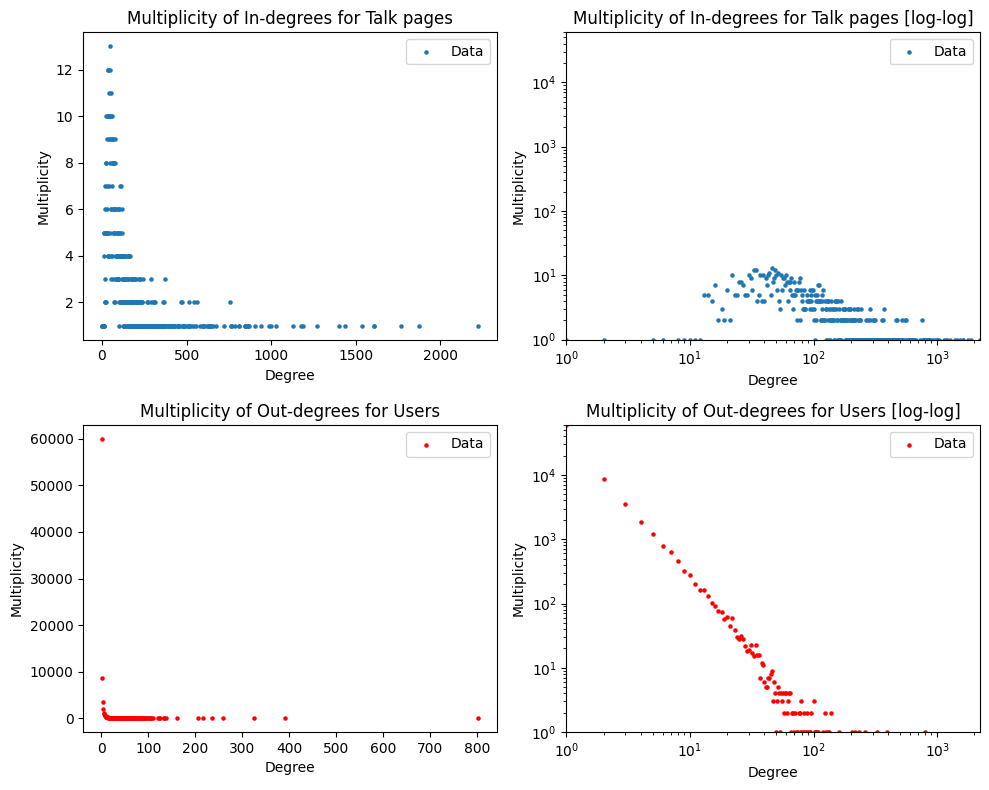

In [ ]:
import math
def fpl(x, a):
    return x ** (-a)

# Plots
fig, axs = plt.subplots(2, 2)

# Sturges rule
no_bins_sturges = int(1 + math.log(len(talk_page_in_degrees.values()), 2))

axs[0, 0].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#hist, bin_edges, _ = axs[0, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, edgecolor='white', label='Data')
#axs[0, 0].set_xticks(bin_edges)
#axs[0, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[0,0].set_title('Multiplicity of In-degrees for Talk pages')
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#axs[0,1].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('Multiplicity of In-degrees for Talk pages [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1, 0].scatter(out_degrees_counts.index, out_degrees_counts.values, color="red", s=5, label='Data')
# hist, bin_edges, _ = axs[1, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, color="red", edgecolor='white', label='Data')
# axs[1, 0].set_xticks(bin_edges)
# axs[1, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[1,0].set_title('Multiplicity of Out-degrees for Users')
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
#axs[1,1].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Multiplicity of Out-degrees for Users [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

# Sentiment analysis per user

For this, we will first need to extract all the comments from all pages, as well as the author of the comment
Then we will assign all comment texts to a single author, and run sentiment analysis on the texts.

In [2]:
author_dict = {}

wikipage_folder = pathlib.Path("./page_contents/")
filenames = list(wikipage_folder.rglob("*.txt"))

#worker_results = [parse_comments_from_pages(filenames[:100])]

with Pool(8) as pool:
    # perform calculations
    worker_results = pool.map(utils.parse_comments_from_pages, utils.chunk_list(filenames[:1000], 20))

failed to parse: page_contents/Talk:Crustacean.txt
failed to parse: page_contents/Talk:Sport of athletics.txt
failed to parse: page_contents/Talk:The Buddha.txt
failed to parse: page_contents/Talk:Weak interaction.txt
failed to parse: page_contents/Talk:News.txt
failed to parse: page_contents/Talk:Economy.txt
failed to parse: page_contents/Talk:Scientific Revolution.txt
failed to parse: page_contents/Talk:City.txt
failed to parse: page_contents/Talk:Natural rubber.txt


In [3]:
import utils
# iterate over the results by the workers
# and transform the output into a dictionary with the users as keys
# and their comments as text
for worker_result in worker_results:
    for filename, page in worker_result:
        for subsection in page["sections"]:
            if subsection.get("heading"):
                for comments in subsection.get("comments"):
                    if comments.get("author"):
                        for author, comment in utils.parse_comment_subcomment(comments):
                            if author not in author_dict:
                                author_dict[author] = []    
                            author_dict[author].append(comment) # this will concatenate the arrays. 
                            # author_dict[author] += (comment) # this will append the comment, thus preserving the comment structure

In [4]:
import utils
# show the top 5 authors written the most text in comment pages
# before tokenizing the comments
items = author_dict.items()
items_sorted = sorted(items, key=lambda x: len(x[1]), reverse=True)
[(author, len(utils.flatten(comments))) for author, comments in items_sorted][:5]

[('InternetArchiveBot', 353030),
 ('PrimeBOT', 142647),
 ('Johnbod', 69313),
 ('jacobolus', 119732),
 ('EMsmile', 94743)]

In [5]:
labMT = pd.read_csv("./labMT.txt", sep="\t")
# to facilitate happiness_average value lookup
labMT.set_index("word", inplace=True)

# Do sentiment analysis
# code taken from assignment 2

def sentiment(tokens):
    if(len(tokens) == 0):
        return
    freq = FreqDist(tokens)

    # filter for the vocabulary we can evaluate with LabMT
    vocab = list(filter(lambda word: word in labMT.index, np.unique(tokens)))

    # array of each token's average happiness weighted by the token's frequency
    weighted_happiness = np.fromiter((freq[word] * labMT.loc[word].happiness_average for word in vocab), dtype=float)
    # each token's frequency
    word_frequencies = np.fromiter((freq[word] for word in vocab), dtype=float)
    return np.sum(weighted_happiness) / np.sum(word_frequencies)

In [6]:
sentiments = {}
for author, text in author_dict.items():
    text = [utils.tokenize_custom(s) for s in text]
    text = utils.flatten(text)
    # compute sentiment for individual rapper wiki page
    if len(text) > 100:
        sentiment_value = sentiment(text)
        if(sentiment_value):
            sentiments[author] = sentiment_value

sentiments_df = pd.DataFrame({"Author": sentiments.keys(), "comment_happiness": sentiments.values()})
# use the author's name as index
sentiments_df.set_index("Author", inplace=True)
sentiments_df.head()

,comment_happiness
Author,
NotTheFakeJTP,5.460000
VHarbee,5.332811
Kwamikagami,5.369535
Double sharp,5.395872
Joiedevivre123321,5.556393


In [7]:
print("Top 10 authors with the happiest comments:")
best_sentiments = sentiments_df.sort_values("comment_happiness", ascending=False).head(10)
best_sentiments

Top 10 authors with the happiest comments:


,comment_happiness
Author,
Lia 199712,5.897957
2A02:CE0:1801:50E:C51D:9330:A910:98D3,5.879540
Praxaquilani,5.757143
Steph44980,5.718022
Vicky gusain,5.714130
AreebaQ,5.698160
205.182.132.75,5.696514
Daria2002ttf,5.695316
Knowledge357111317,5.685217


In [8]:
print("Top 10 authors with the saddest comments:")
worst_sentiments = sentiments_df.sort_values("comment_happiness", ascending=True).head(10)
worst_sentiments

Top 10 authors with the saddest comments:


,comment_happiness
Author,
71.211.175.77,4.886935
108.170.154.240,4.951125
Nathanmcnulty,5.006850
Mfrapps,5.056053
82.132.186.162,5.064206
2607:FB91:8C9E:4883:8D79:621F:1646:2047,5.064207
Capitalismojo,5.064490
David A se,5.066714
ZeroMalone,5.072839


In [9]:
# this shows the original comment before tokenizin
[' '.join(utils.tokenize_custom(s)) for s in author_dict.get(best_sentiments.iloc[0].name)]

['edit request on edit barrier one of australia s most remarkable natural gift the great barrier reef is blessed with the breathtaking beauty of the world s largest coral reef the reef contains an abundance of marine life and comprises of over 3000 individual reef system and coral cay and literally hundred of picturesque tropical island with some of the world most beautiful golden beach because of it natural beauty the great barrier reef ha become one of the world most sought after tourist visitor to the great barrier reef can enjoy many experience including snorkelling scuba diving aircraft or helicopter tour bare boat boat viewing and educational trip cruise ship tour whale watching and swimming with dolphin']

In [10]:
[' '.join(utils.tokenize_custom(s)) for s in author_dict.get(worst_sentiments.iloc[0].name)]

['the addition of slow violence fall under this issue it interesting and insightful in part but it not really a type of violence more like societal reaction or perception of violence case in point stress and the collapse that visited upon glacier a a result of climate change effect those do not meet the definition of violence if you expand the scope and definition of violence a to include the destruction of glacier then bulldozer are violent machine made specifically to do violence which is nut and there no need for this climate change is bad and a good example of slow violence in the sense that it subtly and very slowly lead to wildfire flood hurricane drought and very destructive force of nature where they were not previously accustomed to these are violent event where people die the cause of which is real slow but stress and glacier melting are not themselves any sort of violence it all bad stuff but call it what it is abuse of power corruption propaganda pollution and social manipu

## Results from labmt statistical sentiment analysis

These results show, that it is not beneficial to use the labMT approach to find toxic comments. Different methods should be used for our problem.

What we have seen is that comment sentiment mostly correlates with the topic they are discussing. E.g.: topics discussing the pages fear, Nazi, Hitler have a very low score, but comments discussing e.g. happiness, or the great barrier reef have very high sentiments.

In [11]:
# imports for loading pickles
from nltk.tokenize import word_tokenize
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

In [20]:
# Flatten the dictionary values
flattened_data = [(key, value) for key, values in author_dict.items() for value in values]

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data, columns=['Author', 'Comment'])

# load the vectorizer
with open('./sentiment-models/vectorizer.pkl', 'rb') as file:
    vec = pickle.load(file)

In [13]:
comments_sparse = vec.transform(df['Comment'])

In [16]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((len(df), len(label_cols)))

for i, j in enumerate(label_cols):
    print('predict', j)
    with open(f'./sentiment-models/{j}.pkl', 'rb') as file:
        m,r = pickle.load(file)
    preds[:,i] = m.predict_proba(comments_sparse.multiply(r))[:,1]
    df[j] = preds[:,i]

predict toxic
predict severe_toxic
predict obscene
predict threat
predict insult
predict identity_hate


In [17]:
for row in df[df["toxic"] > 0.6].iterrows():
    print(row[1]["Author"], row[1]["toxic"], row[1]["Comment"])

None 0.668332522171509  
 
 :The stupid man must have been farting. That releases Methane gas, which, of course, will explode in ur face. If u light a cigarette, then ur asking for an explosion. I can assure u that a toilet, with so much water and so little design, will not explode.
 

None 0.8768337254712283  
 *The notion of this whole article is ridiculous because FINANCE is not the SCIENCE OF FUND MANAGEMENT, or any of the other horseshit definitions stated in this article.  FINANCE is the FUNDING OF [THINGS].  Banks finance the construction of a building.  Governments finance the construction of roads and bridges.  Shareholders finance the capital of a corporation.  Fucking progressive juvenile idiots.
 

64.253.108.13 0.6491721194746334  
 ::Someone write a better article fro home this one sucks. -unsigned  <small>—Preceding [[Wikipedia:Signatures|unsigned]] comment added by [[Special:Contributions/64.253.108.13|64.253.108.13]] ([[User talk:64.253.108.13|talk]]) 20:24, 14 August 

In [18]:
author_dict["78.86.130.228"]

[" \n :::::::::::::It's called football. You people are ridiculous. Fifa. No s. Stupid Americans [[Special:Contributions/78.86.130.228|78.86.130.228]] ([[User talk:78.86.130.228|talk]]) 20:26, 17 May 2023 (UTC)\n"]